### In this notebook we take some batches of (images, labels) from the test dataset
### we do predictions and visually compare labels and probability

In [1]:
!pip install efficientnet >> /dev/null

In [1]:
import numpy as np 

import tensorflow as tf
import efficientnet.tfkeras as efn
import glob
import time

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
DEVICE = "GPU" # or "TPU"

# TFRecords file for training/validation/test
DIR_TFREC = './tfrec'
DIR_MODELS = './tpu-models'

IMG_SIZES = 512
IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]

# lower than on TPU, on Udacity we have only 12 GB of GPU mem. To avoid OOM with EFF_NET B4
BATCH_SIZE = 24

FOLDS = 5

# this is the threshold chosen
THRESHOLD = 0.54

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 4

In [3]:
if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


In [4]:
def read_labeled_tfrecord_for_test(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # DON't do image augmentation
    label = example['label']
        
    return image, label 

def decode_image(image_data):
    # qua dovrebbe fare la conversione in RGB come richiesto da EfficientNet
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [5]:
def load_dataset(filenames, labeled=True, ordered=False, isTest=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    
    if isTest == False:
        dataset = dataset.map(read_labeled_tfrecord)
    else:
        dataset = dataset.map(read_labeled_tfrecord_for_test)
    
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_test_dataset(filenames):
    # for predictions it is crucial the ordering
    dataset = load_dataset(filenames, labeled=True, isTest = True, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [6]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = IMG_SIZES, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    # removed label smoothing
    fn_loss = tf.keras.losses.BinaryCrossentropy() 
    
    # loss = [focal_loss]
    model.compile(optimizer = opt, loss = [fn_loss], metrics=['AUC', 'accuracy'])
    
    return model

In [7]:
# models loading

models = []

tStart = time.time()

print('Loading models...')

for fold in range(1, FOLDS + 1):
    print('Loading model:', fold)
    model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    
    model.load_weights(DIR_MODELS + '/fold-%i.h5'%fold)
    
    models.append(model)

print('Loading models completed.')

tEla = time.time() - tStart

print('Total time (sec.) needed: ', round(tEla, 1))

Loading models...
Loading model: 1
71892992/71892840 [==============================] - 1s 0us/step
Loading model: 2
Loading model: 3
Loading model: 4
Loading model: 5
Loading models completed.
Total time (sec.) needed:  69.6


In [8]:
# do predictions with the five models on a batch of images
def predict_batch(batch_images):
    tStart = time.time()
    
    avg_preds = np.zeros((batch_images.shape[0], 1))
    
    for fold in range(0, FOLDS):
        preds = models[fold].predict(batch_images)
        
        avg_preds += preds
    avg_preds = np.round(avg_preds/FOLDS, 2)
    
    tEla = time.time() - tStart
    
    print('Time (sec.) for predictions:', round(tEla, 1))
    print('')
    
    return avg_preds

def show_stats_for_batch(labels, preds, threshold):
    print('Stats for batch:')
    
    y_pred = preds > threshold
    y_pred = y_pred.astype(int)
    
    acc = accuracy_score(labels, y_pred)
    tn, fp, fn, tp = confusion_matrix(labels, y_pred).ravel()
    sens = tp/float(tp + fn)
    
    print('accuracy:', round(acc, 2))
    print('sensitivity:', round(sens, 2))
    print('tp:', tp, 'fn:', fn)
    print('')
    
def show_batch(image_batch, label_batch):
    # first compute predictions
    avg_preds = predict_batch(image_batch)
    
    show_stats_for_batch(label_batch.numpy(), avg_preds, threshold=THRESHOLD)
    
    print('Title is: label expected, probability of pneumonia from models.')
    
    plt.figure(figsize=(16, 16))
    
    for n in range(len(image_batch)):
        ax = plt.subplot(6, 5, n + 1)
        plt.imshow(image_batch[n], cmap='bone')
        
        pred = avg_preds[n, 0]
        
        plt.title(str(int(label_batch[n])) + ", prob: " + str(pred))
        plt.axis("off")
    plt.show()

In [9]:
files_test = tf.io.gfile.glob(DIR_TFREC + '/test*.tfrec')

# get the dataset
dataset = get_test_dataset(files_test)

In [10]:
# create an interator
my_iter = iter(dataset)

### Predictions on some batches

Batch n.  1
Time (sec.) for predictions: 25.9

Stats for batch:
accuracy: 0.75
sensitivity: 0.5
tp: 2 fn: 2

Title is: label expected, probability of pneumonia from models.


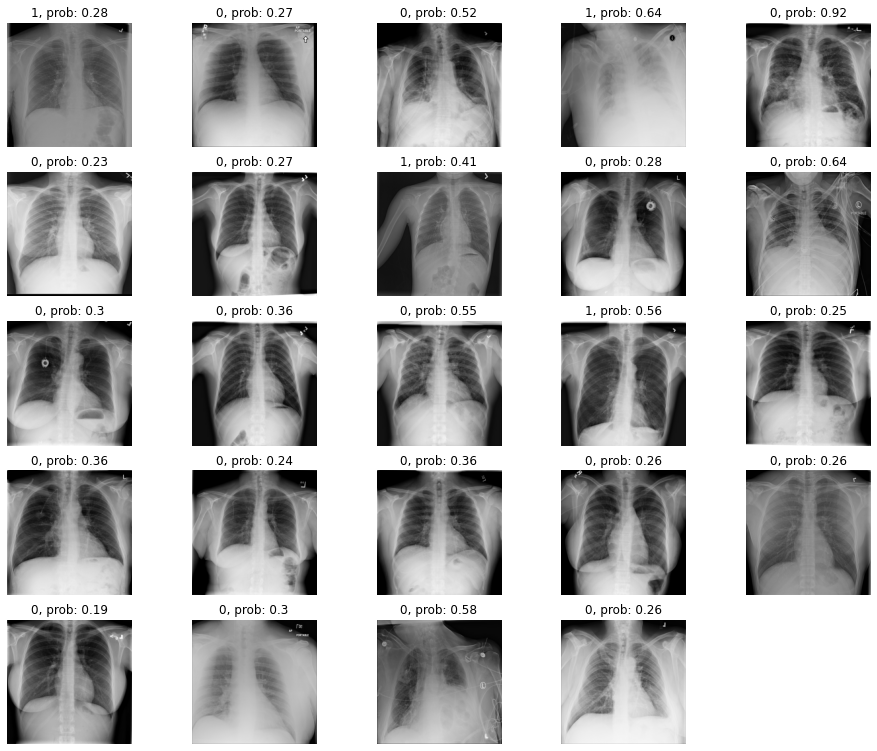

Batch n.  2
Time (sec.) for predictions: 5.8

Stats for batch:
accuracy: 0.88
sensitivity: 0.75
tp: 3 fn: 1

Title is: label expected, probability of pneumonia from models.


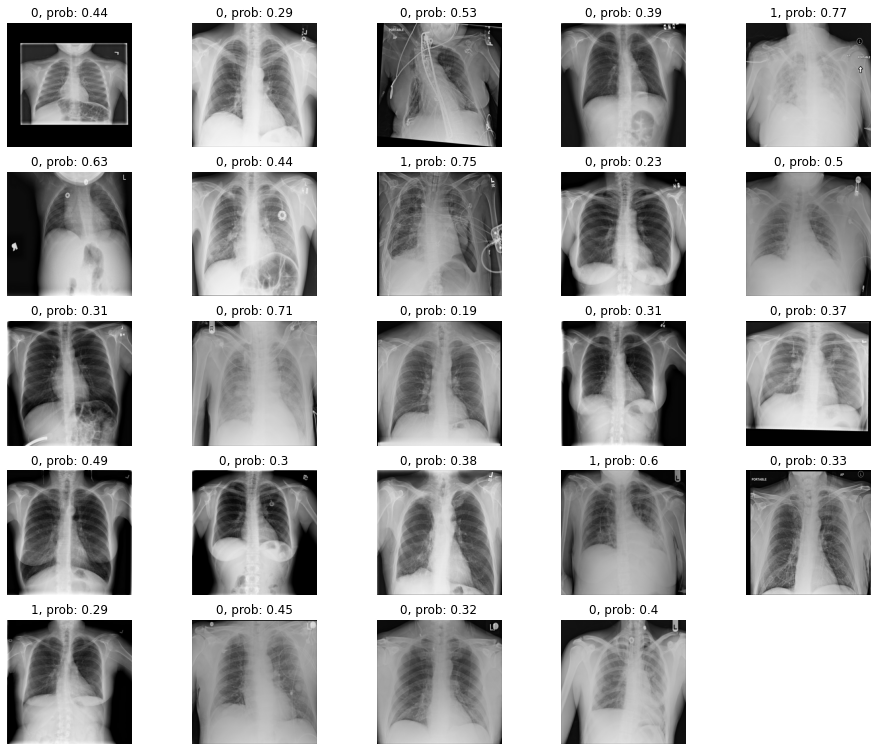

In [11]:
N_BATCHES = 2

for i in range(N_BATCHES):
    print('Batch n. ', i + 1)
    image_batch, label_batch = next(my_iter)
    
    show_batch(image_batch, label_batch)